<a href="https://colab.research.google.com/github/sasansharifipour/Spark_Class/blob/main/train_sheypoor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
file_download_link = "https://drive.google.com/u/0/uc?id=1K2a4mliN8l4aO1S8TWyn29EN25Y4WLlQ&export=download" 
!wget -O data.csv --no-check-certificate "$file_download_link"

--2021-05-22 11:55:13--  https://drive.google.com/u/0/uc?id=1K2a4mliN8l4aO1S8TWyn29EN25Y4WLlQ&export=download
Resolving drive.google.com (drive.google.com)... 142.250.141.113, 142.250.141.138, 142.250.141.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1p3oi49v7jtc3m2vlq6f71u36a53kq1b/1621684500000/14577798666193718332/*/1K2a4mliN8l4aO1S8TWyn29EN25Y4WLlQ?e=download [following]
--2021-05-22 11:55:15--  https://doc-0g-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1p3oi49v7jtc3m2vlq6f71u36a53kq1b/1621684500000/14577798666193718332/*/1K2a4mliN8l4aO1S8TWyn29EN25Y4WLlQ?e=download
Resolving doc-0g-70-docs.googleusercontent.com (doc-0g-70-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to doc-0g-70-docs.googleusercontent.co

In [40]:
import pandas as pd

data = pd.read_csv('data.csv')

df = pd.DataFrame(data)

In [41]:
df.head()

,Unnamed: 0,userid,time,source,adstatus,item,count_views
0,0,1274821301586/54e79450-bbee-4770-9e47-1d56e120...,2021-05-05 18:00:00.000,Chrome,۳ روز پیش,A,1
1,1,1274821301586/54e79450-bbee-4770-9e47-1d56e120...,2021-05-05 18:00:00.000,Chrome,۴ روز پیش,A,1
2,2,1325384907441/5e5766d8-46cb-480d-886a-7d557542...,2021-05-01 10:00:00.000,Android,۲ روز پیش,B,1
3,3,1325384907441/5e5766d8-46cb-480d-886a-7d557542...,2021-05-01 10:00:00.000,Android,۶ روز پیش,B,1
4,4,1337524499886/ad464731-6288-4e04-8a1a-aa9c004f...,2021-05-03 05:00:00.000,Android,ساعاتی پیش,A,1


In [124]:
import networkx as nx

def create_graph(data):
  graph = nx.DiGraph()

  for index, row in data.iterrows():
    source_node = row["userid"]
    destination_node = str(row["adstatus"]) + "_" + str(row["item"])
    item_destination_node = str(row["item"])
    source_destination_node = str(row["source"])

    prior_weight = row["count_views"]

    graph.add_node(source_node, node_type='user')
    #graph.add_node(destination_node, node_type='item')
    graph.add_node(item_destination_node, node_type='onlyitem')
    #graph.add_node(source_destination_node, node_type='source')

    node_attributes = graph.get_edge_data(source_node, destination_node)

    if (node_attributes is not None):
      prior_weight = prior_weight + node_attributes["weight"]

    graph.add_weighted_edges_from([
                                   #(source_node, destination_node, prior_weight),
                                   (source_node, item_destination_node, prior_weight),
                                   #(source_node, source_destination_node, prior_weight),
                                   #(destination_node, item_destination_node, prior_weight)
                                   ])

  return graph


graph = create_graph(df)

In [125]:
page_ranks = nx.pagerank(graph, weight ='weight', max_iter =1000, alpha=0.85)

In [126]:
user_nodes = list({n for n, d in graph.nodes(data=True) if d["node_type"] == "user"})
item_nodes = list({n for n, d in graph.nodes(data=True) if d["node_type"] == "item"})
page_ranks.get(user_nodes[0])

1.020094671639044e-05

In [133]:
min(page_ranks.values())

1.020094671639044e-05

In [134]:
def extract_features(graph, page_ranks):
  user_nodes = list({n for n, d in graph.nodes(data=True) if d["node_type"] == "user"})
  #item_nodes = list({n for n, d in graph.nodes(data=True) if d["node_type"] == "item"})
  onlyitem_nodes = list({n for n, d in graph.nodes(data=True) if d["node_type"] == "onlyitem"})
  #source_nodes = list({n for n, d in graph.nodes(data=True) if d["node_type"] == "source"})

  column_names = []
  #column_names = item_nodes.copy()
  column_names.extend(onlyitem_nodes.copy())
  #column_names.extend(source_nodes.copy())
  column_names.insert(0, 'user_rank')
  column_names.insert(0, 'user_id')

  data = []

  for user in user_nodes :
    user_rank = page_ranks.get(user)
    row_data = [user, user_rank]

    #for item in item_nodes :
      #item_rank = page_ranks.get(item)

      #node_weight = 0
      #node_attributes = graph.get_edge_data(user, item)
      
      #if (node_attributes is not None):
      #  node_weight = node_attributes["weight"]
        
      #calculated_feature = node_weight * user_rank * item_rank
      #row_data.append(calculated_feature)
    
    for item in onlyitem_nodes :
      item_rank = page_ranks.get(item)

      node_weight = 0
      node_attributes = graph.get_edge_data(user, item)
      
      if (node_attributes is not None):
        node_weight = node_attributes["weight"]
        
      calculated_feature = node_weight * user_rank * item_rank
      row_data.append(calculated_feature)

    #for item in source_nodes :
      #item_rank = page_ranks.get(item)

      #node_weight = 0
      #node_attributes = graph.get_edge_data(user, item)
      
      #if (node_attributes is not None):
      #  node_weight = node_attributes["weight"]
        
      #calculated_feature = node_weight * user_rank * item_rank
      #row_data.append(calculated_feature)

    data.append(row_data)
  
  df = pd.DataFrame(data, columns = column_names)
  return df

In [135]:
df_features = extract_features(graph, page_ranks)

In [136]:
df_features.head(10)

,user_id,user_rank,C,B,A
0,1620032121394/12855882-f4d7-4574-89e4-83f3a2e5...,0.00001,0.000000e+00,0.000000,0.000003
1,1620055581050/323a7135-e206-4a0d-9c54-27f88f2c...,0.00001,0.000000e+00,0.000000,0.000003
2,1618305496872/ef33b880-f26a-4f79-815d-ddd161d1...,0.00001,0.000000e+00,0.000002,0.000000
3,1619867213109/59da4193-ca06-41cb-9b82-b6166c0d...,0.00001,0.000000e+00,0.000000,0.000003
4,1615746867959/ccec5c55-2feb-4a22-b6c6-76dbdaab...,0.00001,0.000000e+00,0.000002,0.000000
5,1620357890941/511f077d-3eeb-41f1-ac6d-8a2feb35...,0.00001,0.000000e+00,0.000006,0.000000
6,1620386071700/dd966013-97f9-457f-9d06-37c7f30c...,0.00001,0.000000e+00,0.000000,0.000006
7,1616485089974/de999625-1fff-4f37-83aa-d14babdc...,0.00001,4.620682e-07,0.000000,0.000000
8,1618853494128/2dd66632-e071-4981-bf5a-c7f78a87...,0.00001,0.000000e+00,0.000000,0.000003
9,1617287051014/5d048e6d-f2c2-437b-b13d-06855d99...,0.00001,0.000000e+00,0.000000,0.000017


In [137]:
from sklearn import preprocessing

df_without_user_id = df_features.iloc[:, 1::].to_numpy()

min_max_scaler = preprocessing.MinMaxScaler()
df_without_user_id_scaled = min_max_scaler.fit_transform(df_without_user_id)

df_scaled = pd.DataFrame(df_without_user_id_scaled)
df_scaled.head()

,0,1,2,3
0,0.0,0.0,0.00,0.027027
1,0.0,0.0,0.00,0.027027
2,0.0,0.0,0.05,0.000000
3,0.0,0.0,0.00,0.027027
4,0.0,0.0,0.05,0.000000


In [138]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit(df_without_user_id_scaled)
pca_data = pca.transform(df_without_user_id_scaled)

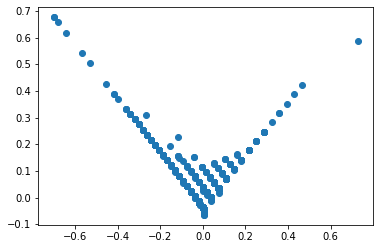

In [139]:
import matplotlib.pyplot as plt

plt.scatter(pca_data[:,0], pca_data[:,1])
plt.show()

In [140]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=0).fit(df_without_user_id)

In [141]:
lst = list(kmeans.labels_)
for i in range(30):
  print(str(i) + ":" + str(lst.count(i)))

0:22356
1:2410
2:14105
3:193
4:4937
5:6
6:711
7:39
8:2808
9:4352
10:0
11:0
12:0
13:0
14:0
15:0
16:0
17:0
18:0
19:0
20:0
21:0
22:0
23:0
24:0
25:0
26:0
27:0
28:0
29:0


In [ ]:
df["adstatus"].value_counts()

ساعاتی پیش    48208
۱ روز پیش     18756
۱ هفته پیش    15165
دقایقی پیش    13422
لحظاتی پیش    12156
۲ روز پیش     11864
۲ هفته پیش    10335
۳ روز پیش      8621
۳ هفته پیش     7908
۴ روز پیش      6951
۵ روز پیش      5864
۶ روز پیش      4939
۴ هفته پیش     2446
۱ ماه پیش      1104
۲ ماه پیش       688
۷ ماه پیش       264
۳ ماه پیش       232
۴ ماه پیش       202
۱ سال پیش       172
۵ ماه پیش        84
۶ ماه پیش        38
۱۱ ماه پیش       25
۱۰ ماه پیش       24
۸ ماه پیش        24
۹ ماه پیش        23
Name: adstatus, dtype: int64

In [ ]:
pd.get_dummies(df, columns=["item","adstatus", "source"]).head()

,Unnamed: 0,userid,time,count_views,item_A,item_B,item_C,adstatus_دقایقی پیش,adstatus_ساعاتی پیش,adstatus_لحظاتی پیش,adstatus_۱ روز پیش,adstatus_۱ سال پیش,adstatus_۱ ماه پیش,adstatus_۱ هفته پیش,adstatus_۱۰ ماه پیش,adstatus_۱۱ ماه پیش,adstatus_۲ روز پیش,adstatus_۲ ماه پیش,adstatus_۲ هفته پیش,adstatus_۳ روز پیش,adstatus_۳ ماه پیش,adstatus_۳ هفته پیش,adstatus_۴ روز پیش,adstatus_۴ ماه پیش,adstatus_۴ هفته پیش,adstatus_۵ روز پیش,adstatus_۵ ماه پیش,adstatus_۶ روز پیش,adstatus_۶ ماه پیش,adstatus_۷ ماه پیش,adstatus_۸ ماه پیش,adstatus_۹ ماه پیش,source_Android,source_Chrome
0,0,1274821301586/54e79450-bbee-4770-9e47-1d56e120...,2021-05-05 18:00:00.000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,1274821301586/54e79450-bbee-4770-9e47-1d56e120...,2021-05-05 18:00:00.000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,2,1325384907441/5e5766d8-46cb-480d-886a-7d557542...,2021-05-01 10:00:00.000,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,3,1325384907441/5e5766d8-46cb-480d-886a-7d557542...,2021-05-01 10:00:00.000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,4,1337524499886/ad464731-6288-4e04-8a1a-aa9c004f...,2021-05-03 05:00:00.000,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
